# 복습과제 1

## 데이터 작업하기

In [ ]:
# Load torch

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
# 공개 데이터셋에서 학습 데이터를 내려받습니다. (Use MNIST Data)
# Download FashionMNIST Dataset and transform to Tensor
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# 공개 데이터셋에서 테스트 데이터를 내려받습니다.
# Download FashionMNIST Dataset and transform to Tensor
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.9MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 166kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.15MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 23.5MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Dataset 을 DataLoader 의 인자로 전달합니다. 이는 데이터셋을 순회 가능한 객체(iterable)로 감싸고, 자동화된 배치(batch), 샘플링(sampling), 섞기(shuffle) 및 다중 프로세스로 데이터 불러오기(multiprocess data loading)를 지원합니다. 여기서는 배치 크기(batch size)를 64로 정의합니다. 즉, 데이터로더(dataloader) 객체의 각 요소는 64개의 특징(feature)과 정답(label)을 묶음(batch)으로 반환합니다.

In [ ]:
batch_size = 64

# 데이터로더를 생성합니다.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## 모델 만들기

In [ ]:
# 학습에 사용할 CPU나 GPU, MPS 장치를 얻습니다.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
# 모델을 정의합니다.
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024), #784개의 input -> 1024개의 hidden layer 1
            nn.ReLU(),
            nn.Linear(1024, 256), # 512 -> 512 hidden layer 2
            nn.ReLU(),
            nn.Linear(256, 10) # 512 -> 10 output
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


## 모델 매개변수 최적화

In [ ]:
loss_fn = nn.CrossEntropyLoss() # cross-entropy loss 이용
optimizer = torch.optim.SGD(model.parameters(), lr=7e-3) # sgd algorithm으로 최적화

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y) # loss 계산하는 부분

        # 역전파
        optimizer.zero_grad() # gradient를 0으로 초기화
        loss.backward() # 역전파로 계산하는 단계
        optimizer.step() # 최적화

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306671  [   64/60000]
loss: 2.193576  [ 6464/60000]
loss: 1.983074  [12864/60000]
loss: 1.784777  [19264/60000]
loss: 1.428233  [25664/60000]
loss: 1.274263  [32064/60000]
loss: 1.159391  [38464/60000]
loss: 1.010228  [44864/60000]
loss: 1.006893  [51264/60000]
loss: 0.899246  [57664/60000]
Test Error: 
 Accuracy: 68.9%, Avg loss: 0.893309 

Epoch 2
-------------------------------
loss: 0.932837  [   64/60000]
loss: 0.944059  [ 6464/60000]
loss: 0.686102  [12864/60000]
loss: 0.863058  [19264/60000]
loss: 0.726877  [25664/60000]
loss: 0.713785  [32064/60000]
loss: 0.790483  [38464/60000]
loss: 0.723476  [44864/60000]
loss: 0.744621  [51264/60000]
loss: 0.701216  [57664/60000]
Test Error: 
 Accuracy: 75.8%, Avg loss: 0.688993 

Epoch 3
-------------------------------
loss: 0.645306  [   64/60000]
loss: 0.738356  [ 6464/60000]
loss: 0.492164  [12864/60000]
loss: 0.723336  [19264/60000]
loss: 0.623506  [25664/60000]
loss: 0.608233  [32064/600

## 모델 저장하기

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## 모델 불러오기

In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<ipython-input-56-b4ef1eff0e4c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


<All keys matched successfully>

## 예측하기

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# 복습과제 2

### Q1) What is the number of total parameters in this MLP model? Why?

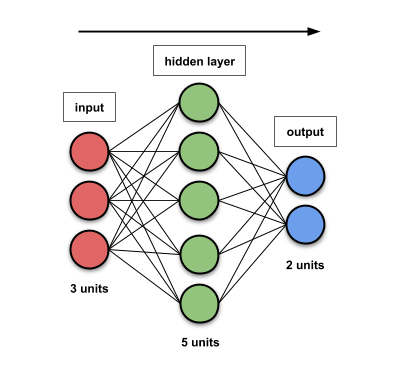

Your Answer: 32

input layer -> hidden layer : 3*5(weight) + 5(bias) = 20

hidden layer -> output layer : 5*2(weight) + 2(bias) = 12

total : 20 + 12 = 32

### Q2) Using the Gradient Descent Algorithm, the loss of the model will decrease continuously to a specific point, which is a minimum. Is it the optimal point? Why or why not?

Your Answer: 맞을 수도 있고, 아닐 수도 있다. Global minimum이 아니라 local minimum일 수 있다.

이걸 어느정도 해소하기 위해, momentum을 활용한 optimizer 사용 -> momentum, adam 등

### Q3) Is it possible to decrease the training error to zero? *(Hint: Think about the Universal Approximation Theorem)*

Your Answer: Universal Approximation Theorem -> 신경망이 이론적으로는 거의 모든 연속적인 함수들을 근사할 수 있음을 보장

충분히 큰 은닉층을 가진 신경망은 훈련 데이터에서 입력과 출력 간의 관계를 완벽하게 학습할 수 있다. -> but, 과적합

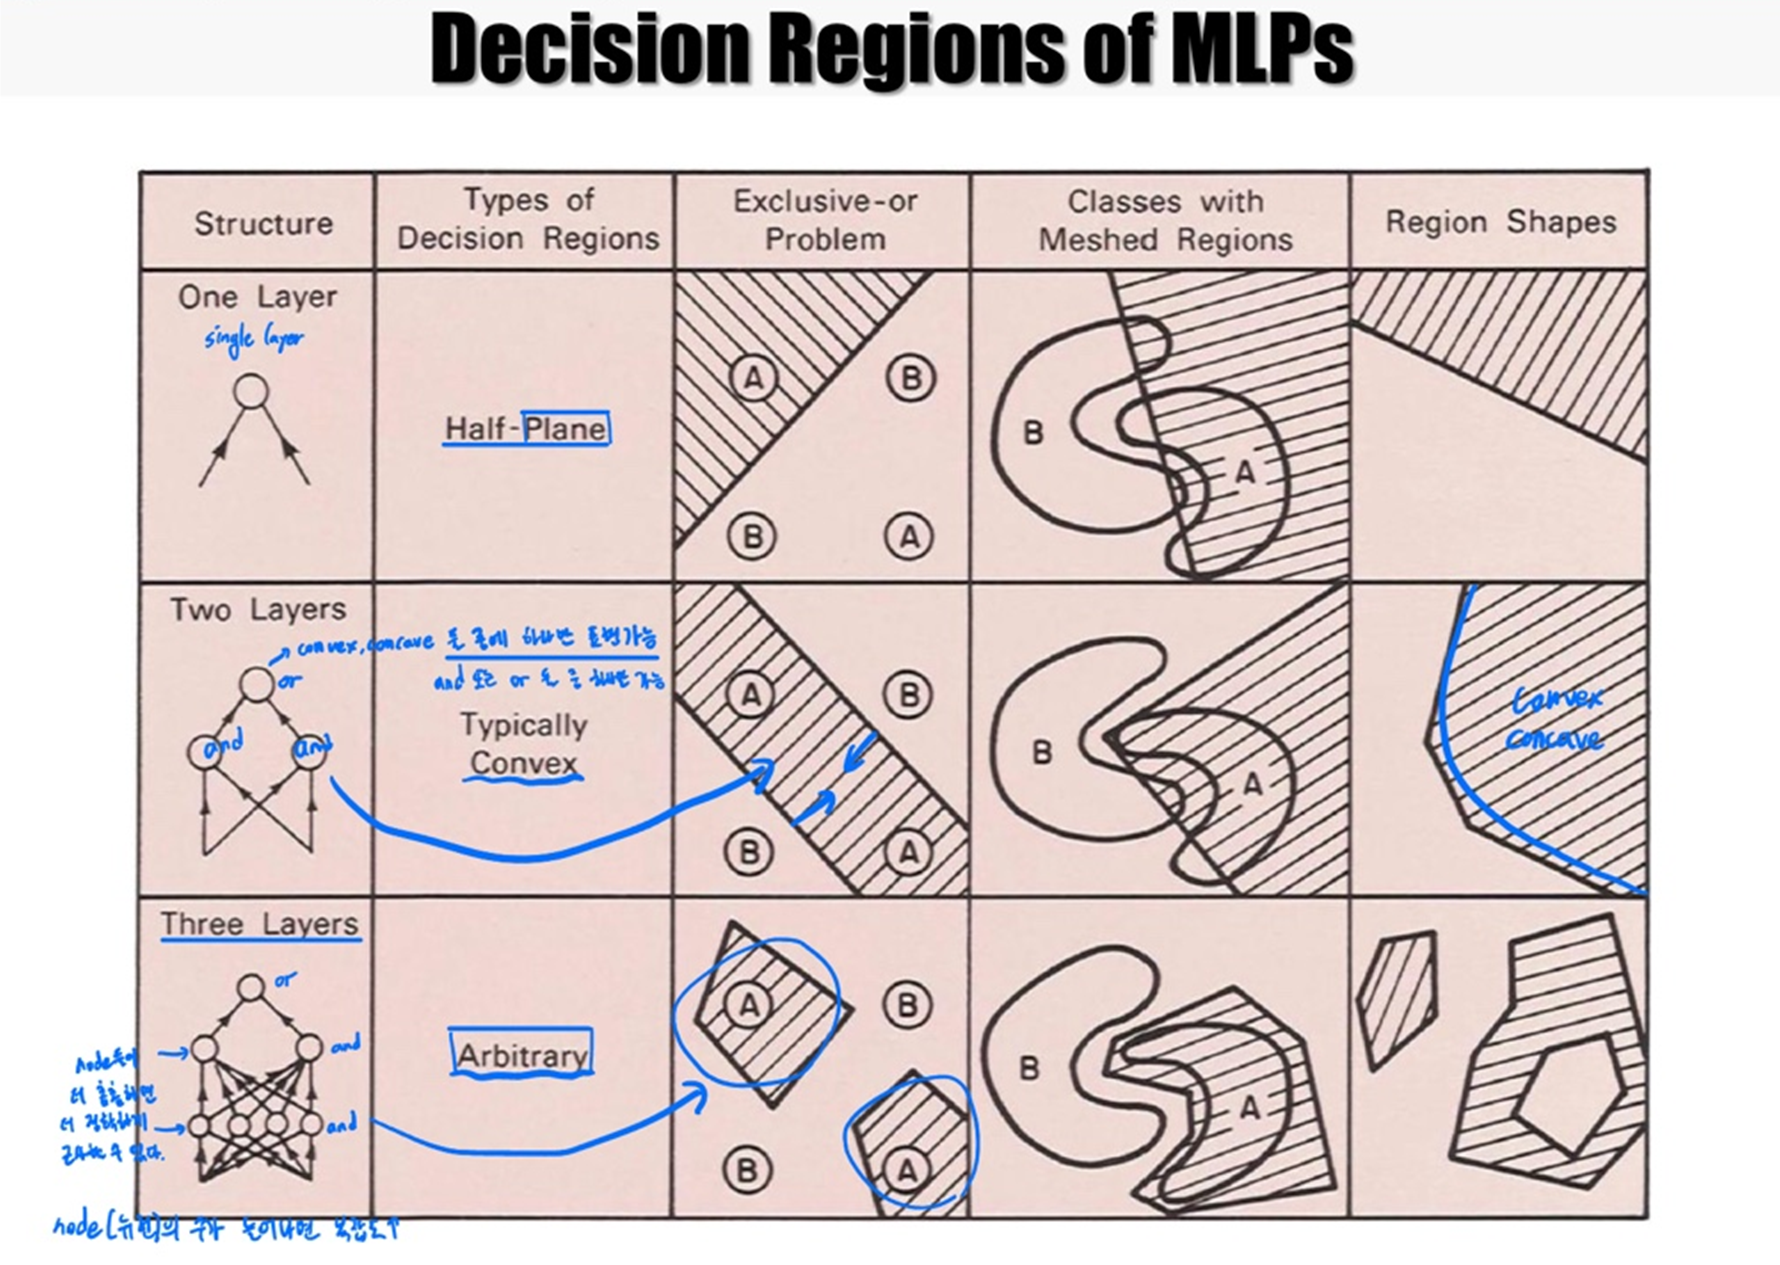

### Q4) Is deep learning the best method to build models? That is, does deeper networks generalize better than other methods? *(Hint: it is somehow related with question 3)*

Your Answer: No.

네트워크가 너무 깊거나 복잡해지면 과적합(overfitting) 문제가 발생할 수 있다. 즉, 모델이 훈련 데이터에 너무 맞춰져서 테스트 데이터에 대한 예측 성능이 떨어질 수 있다.

따라서, 모델이 과적합되지 않도록 적절한 정규화 기법(예: Dropout, L2 Regularization 등)을 사용해야 한다.